# Pokemon detector

In [1]:
import tensorflow as tf
print (tf.__version__)

2.3.1


In [3]:
import numpy as np
import imageio
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from tensorflow.keras.layers import Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from skimage.transform import resize

## Reading pokemons that will be detecting

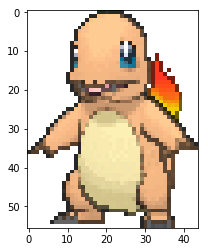

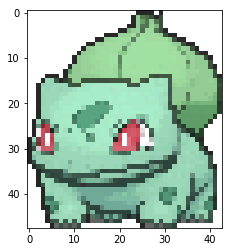

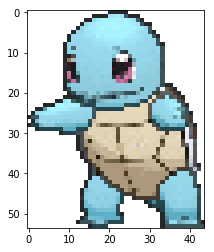

In [7]:
ch = imageio.imread('img/charmander-tight.png')
bb = imageio.imread('img/bulbasaur-tight.png')
sq = imageio.imread('img/squirtle-tight.png')
plt.imshow(ch)
plt.show()
plt.imshow(bb)
plt.show()
plt.imshow(sq)
plt.show()

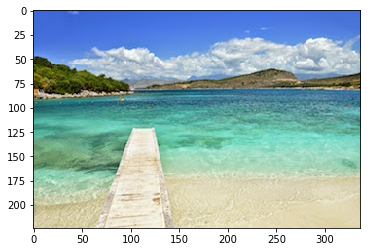

In [11]:
example_backgroud = imageio.imread('img/backgrounds/5.jpg')
plt.imshow(example_backgroud)

## Data Preparation

In [12]:
pokemon_dim = 200
ch = np.array(ch)
bb = np.array(bb)
sq = np.array(sq)
CH_H, CH_W, CH_C = ch.shape
BB_H, BB_W, BB_C = bb.shape
SQ_H, SQ_W, SQ_C = sq.shape

pokemon_data = [
    [ch, CH_H, CH_W, CH_C],
    [bb, BB_H, BB_W, BB_C],
    [sq, SQ_H, SQ_W, SQ_C],
]
class_names = ['Charmander', 'Bulbasaur', 'Squirtle']

### Creating custom loss function 

In [16]:
def custom_loss(y_true, y_pred):
    # target (row, col, depth, width, class1, class2, class3, object_appeared)
    bce = binary_crossentropy(y_true[:, 4], y_pred[:, 4]) # Localization
    cce = categorical_crossentropy(y_true[:, 4:7], y_pred[:, 4:7]) # Object class
    bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1]) # Object appeared
    
    return bce * y_true[:, -1] + cce * y_true[:, -1] + 0.5 + bce2

### Creating model from VGG 16

In [18]:
def make_model():
    vgg = tf.keras.applications.VGG16(
        input_shape=[pokemon_dim, pokemon_dim, 3],
        include_top=False,
        weights='imagenet')
    x = Flatten()(vgg.output)
    x1 = Dense(4, activation='sigmoid')(x) # Localization
    x2 = Dense(3, activation='softmax')(x) # Object class
    x3 = Dense(1, activation='sigmoid')(x) # Object appeared
    x = Concatenate()([x1, x2, x3])
    model = Model(vgg.input, x)
    # model.compile(loss=custom_loss, optimizer=SGD(learning_rate=0.01, momentum=0.9))
    model.compile(loss=custom_loss, optimizer=Adam(lr=0.0001))
    return model

In [19]:
from glob import glob

### Loading Backgrounds for generator

In [22]:
backgrounds = []
background_files = glob('img/backgrounds/*.jpg')
for f in background_files:
    bg = np.array(image.load_img(f))
    backgrounds.append(bg)

### Pokemon Image Generator 

In [28]:
def pokemon_generator_multiclass(batch_size=64):
  while True:
    # Each epoch will have 50 batches
    for _ in range(50):
      X = np.zeros((batch_size, pokemon_dim, pokemon_dim, 3))
      Y = np.zeros((batch_size, 8))
      
      for i in range(batch_size):
        # Select a random background
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_h = np.random.randint(bg_h - pokemon_dim)
        rnd_w = np.random.randint(bg_w - pokemon_dim)
        X[i] = bg[rnd_h:rnd_h+pokemon_dim,rnd_w:rnd_w+pokemon_dim].copy()
        
        # 25% no object, 25% + 25% + 25% for the 3 classes
        appear = (np.random.random() < 0.75)
        if appear:
          
          # Choose a pokemon
          pk_idx = np.random.randint(3)
          pk, h, w, _ = pokemon_data[pk_idx]

          # Eesize object 
          scale = 0.5 + np.random.random()
          new_height = int(h * scale)
          new_width = int(w * scale)
          obj = resize(
              pk,
              (new_height, new_width),
              preserve_range=True).astype(np.uint8) # keep it from 0..255

          if np.random.random() < 0.5:
            obj = np.fliplr(obj)

          # Choose a random location to store the object
          row0 = np.random.randint(pokemon_dim - new_height)
          col0 = np.random.randint(pokemon_dim - new_width)
          row1 = row0 + new_height
          col1 = col0 + new_width

          mask = (obj[:,:,3] == 0) # Find where the pokemon is 0
          bg_slice = X[i,row0:row1,col0:col1,:] # Where we want to place `obj`
          bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
          bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
          X[i,row0:row1,col0:col1,:] = bg_slice # Put the slice back

          # Location
          Y[i,0] = row0/pokemon_dim
          Y[i,1] = col0/pokemon_dim
          Y[i,2] = (row1 - row0)/pokemon_dim
          Y[i,3] = (col1 - col0)/pokemon_dim

          # Class
          Y[i,4 + pk_idx] = 1
        
        # did the pokemon appear?
        Y[i,7] = appear
      
      yield X / 255., Y

### Testing Generator

In [29]:
xx = None
yy = None
for x, y in pokemon_generator_multiclass():
  xx, yy = x, y
  break

[0.19  0.455 0.245 0.22  0.    1.    0.    1.   ]
percent no obj: 0.296875
percent charmander: 0.21875
percent bulbasaur: 0.28125
percent squirtle: 0.203125


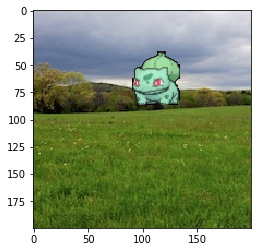

In [30]:
n = yy.shape[0]
idx = np.random.randint(n)
plt.imshow(xx[idx]);
print(yy[idx])
print("percent no obj:", (yy[:,7] == 0).sum() / n)
print("percent charmander:", yy[:,4].sum() / n)
print("percent bulbasaur:", yy[:,5].sum() / n)
print("percent squirtle:", yy[:,6].sum() / n)

### Training Model

In [31]:
model = make_model()
model.fit_generator(pokemon_generator_multiclass(), 
                    steps_per_epoch=50, 
                    epochs=5)

58892288/58889256 [==============================] - 246s 4us/step
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
50/50 [==============================] - 2093s 42s/step - loss: 0.9527
Epoch 2/5
50/50 [==============================] - 1997s 40s/step - loss: 0.7695
Epoch 3/5
50/50 [==============================] - 1981s 40s/step - loss: 0.5166
Epoch 4/5
50/50 [==============================] - 1967s 39s/step - loss: 0.5020
Epoch 5/5
50/50 [==============================] - 2011s 40s/step - loss: 0.5003
